In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ec = pd.read_parquet('../data/processed/reddit_btc_wsbelite_relevant_posts_with_sentiment.parquet')
yc = pd.read_parquet('../data/processed/reddit_relevant_posts_with_sentiment_yc.parquet')
jl1 = pd.read_parquet('../data/processed/bitcoin_subreddit_relevant_posts_with_sentiment.parquet')
jl2 = pd.read_parquet('../data/processed/cryptocurrency_subreddit_relevant_posts_with_sentiment.parquet')
jc = pd.read_parquet('../data/processed/bitcoinBeginners_BitcoinMining_reddit_relevant_posts_with_sentiment.parquet')
print('jl2', jl2.columns) #missing sentiment score
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
jl2["sentiment_score"] = jl2["overall_sentiment"].map(sentiment_mapping)
print('ec', ec.columns)

df = pd.concat([ec, yc, jl1, jl2, jc], ignore_index=True)

jl2 Index(['post_id', 'title', 'body', 'author', 'upvotes', 'downvotes', 'score',
       'num_comments', 'url', 'created_at', 'subreddit', 'date_created',
       'is_relevant', 'year', 'week', 'day', 'top_comments',
       'overall_sentiment'],
      dtype='object')
ec Index(['post_id', 'title', 'body', 'author', 'upvotes', 'downvotes', 'score',
       'num_comments', 'url', 'created_at', 'subreddit', 'date_created',
       'is_relevant', 'year', 'week', 'day', 'top_comments',
       'overall_sentiment', 'sentiment_score'],
      dtype='object')


In [2]:
jan_march = pd.read_parquet('../data/processed/reddit_relevant_posts_jan_to_march_with_sentiment.parquet')

df = pd.concat([df, jan_march], ignore_index=True)
print(df.shape)
#check duplicate post via post_id
print(df[df.duplicated(subset=['post_id'])].shape) # from jan
#drop dups
df = df.drop_duplicates(subset=['post_id'])
print(df.shape)


(2339, 19)
(17, 19)
(2322, 19)


In [3]:
#drop rows between Nov 2024 and Jan 2025 that have less than 10 upvotes
df = df[((df["upvotes"] >= 50) & (df["created_at"]>= "2024-11-01") & (df["created_at"]<= "2025-01-31")) | (df["created_at"]<"2024-11-01") | (df["created_at"] > "2025-01-31") ]
print(df.shape)


(1960, 19)


## EDA

below we can see that aggregating over the 10 most active bitcoin related subreddits, the post density becomes a lot less sparse. in fact, comparing against BTC daily trading volume, we see roughly a similar shape, with a lull in activity in Q3. so less of a concern with regards to completeness of reddit data that we can model our sentiment with.

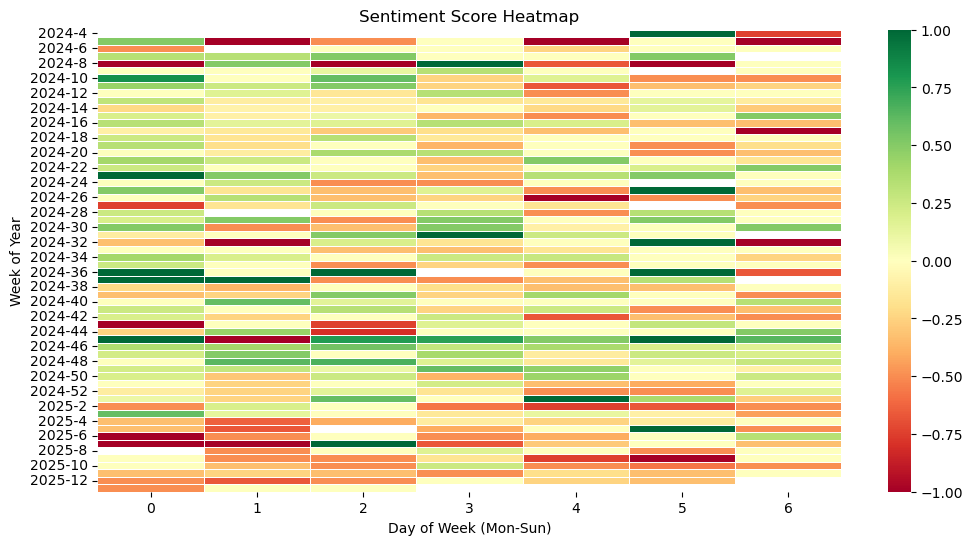

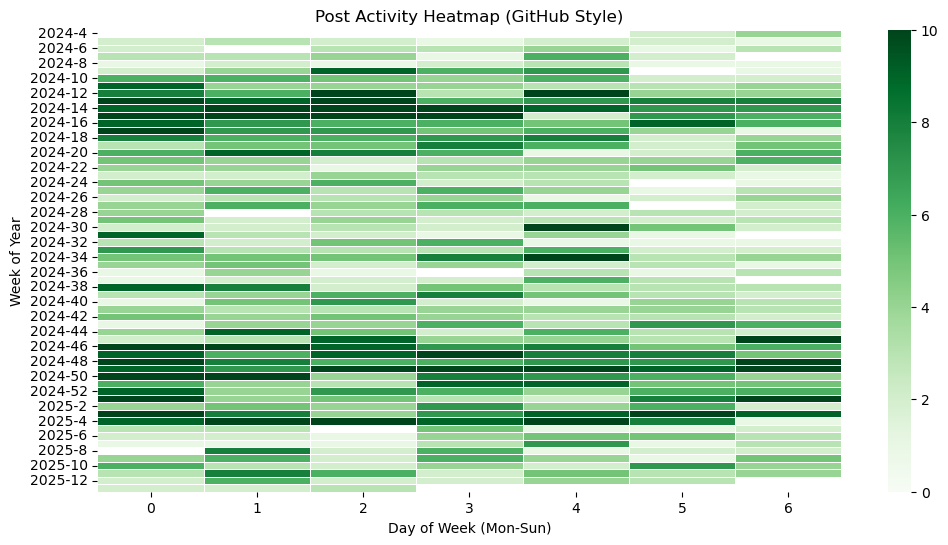

C:\Users\Justin\AppData\Local\Temp\ipykernel_24604\820456992.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume['datetime'] = pd.to_datetime(volume['datetime'])


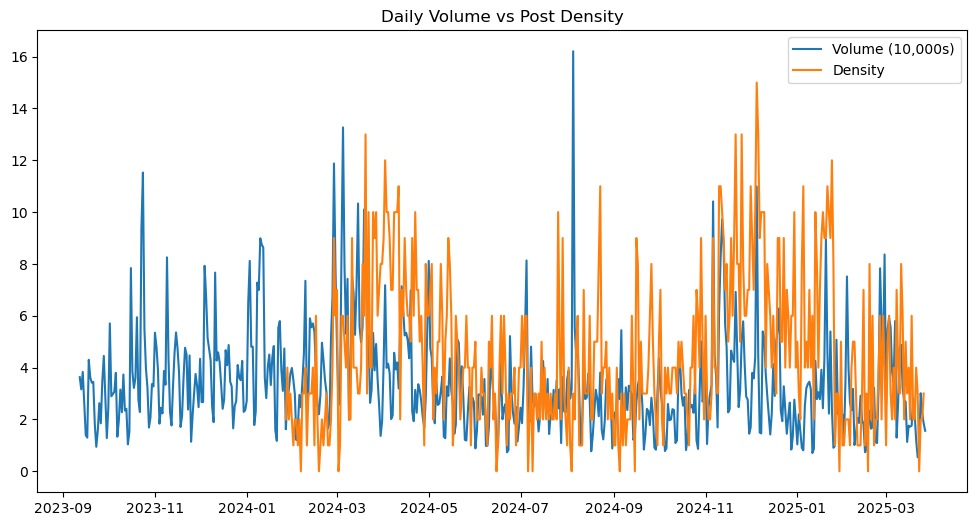

In [4]:
heatmap_data = df.groupby(['year', 'week', 'day']).size().unstack()
heatmap_data_2 = df.groupby(["year", "week", "day"])["sentiment_score"].mean().unstack()
plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data_2, cmap="RdYlGn", linewidths=0.5, linecolor="white", center=0, vmin=-1, vmax=1)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Sentiment Score Heatmap")
plt.show()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="Greens", linewidths=0.5, linecolor="white", vmin=0, vmax=10)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Post Activity Heatmap (GitHub Style)")

plt.show()


btc = pd.read_csv("../data/processed/btc_usdt_hourly_processed.csv")
volume = btc[['datetime', 'VOLUME']]
#daily volume
volume['datetime'] = pd.to_datetime(volume['datetime'])
volume = volume.set_index('datetime')
volume = volume.resample('D').sum()

#df daily post density
df['date_created'] = pd.to_datetime(df['date_created'])
df = df.set_index('date_created')
density = df.resample('D').size()

plt.figure(figsize=(12, 6))
plt.plot(volume /10000, label='Volume (10,000s)')
plt.plot(density , label='Density')
plt.legend()
plt.title('Daily Volume vs Post Density')
plt.show()




C:\Users\Justin\AppData\Local\Temp\ipykernel_24604\22239851.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = df['created_at'].min().floor('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_24604\22239851.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_time = df['created_at'].max().ceil('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_24604\22239851.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                           smoothed_sentiment
2024-01-27 13:00:00+00:00            0.000000
2024-01-27 14:00:00+00:00            1.983623
2024-01-27 15:00:00+00:00            1.900289
2024-01-27 16:00:00+00:00            1.816956
2024-01-27 17:00:00+00:00            1.733623


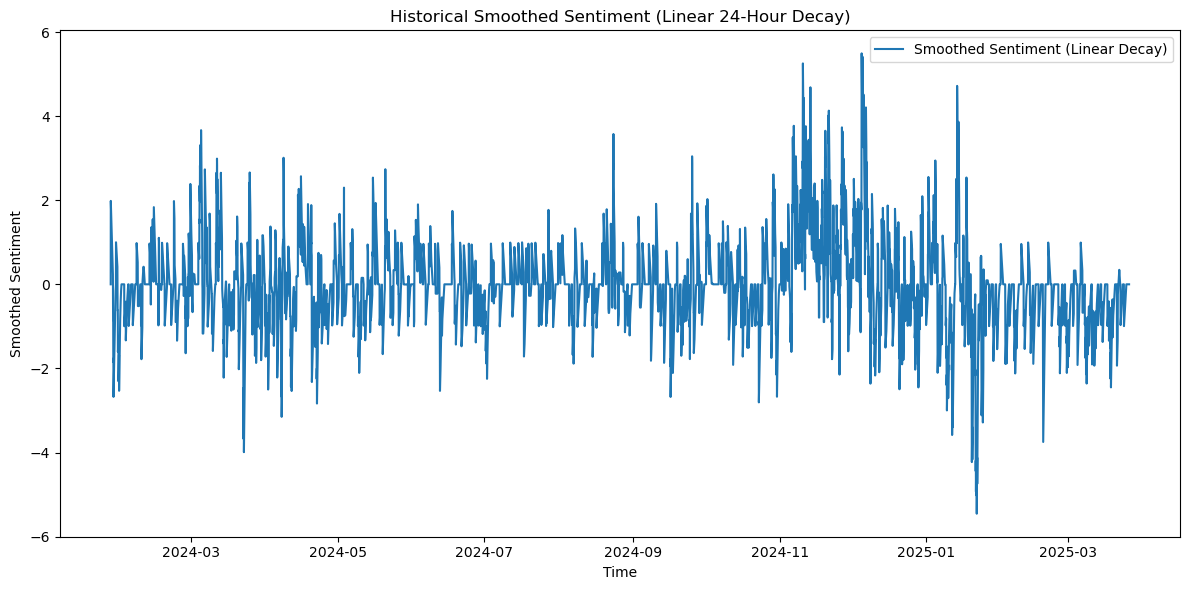

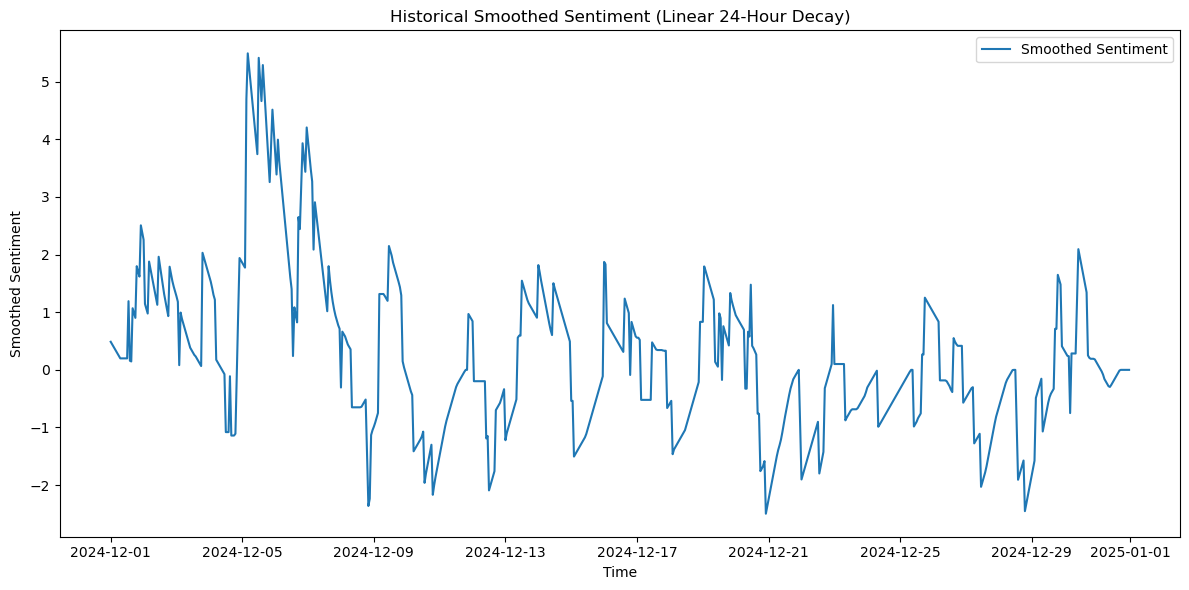

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])

# Define the start and end time for the analysis (rounded to the nearest hour)
start_time = df['created_at'].min().floor('H')
end_time = df['created_at'].max().ceil('H')

# Create an hourly date range
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_linear(t):
    """
    Compute the smoothed sentiment at time t as the weighted sum of sentiment scores
    in the past 24 hours. Each news event decays linearly: its weight is 
    1 - (time difference in hours)/24.
    """
    # Define the 24-hour window for events affecting time t
    window_start = t - pd.Timedelta(hours=24)
    
    # Filter news events that occurred in the last 24 hours (excluding events after t)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    
    if df_window.empty:
        return 0.0  # No news, no sentiment effect.
    
    # Calculate the time difference (in hours) between t and each news event
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Linear decay: weight = 1 - (difference/24)
    weights = 1 - (time_diffs / 24)
    weights = weights.clip(lower=0)  # Ensure no negative weights
    
    # Compute the weighted sentiment sum
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# Apply the function to each timestamp in the hourly index
smoothed_sentiments = [compute_smoothed_sentiment_linear(t) for t in hourly_index]

# Create a DataFrame with the results
df_sentiment = pd.DataFrame({'smoothed_sentiment': smoothed_sentiments}, index=hourly_index)

# Display the first few rows
print(df_sentiment.head())

# Optionally, plot the smoothed sentiment time series 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment'], label='Smoothed Sentiment (Linear Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment'], label='Smoothed Sentiment')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Justin\AppData\Local\Temp\ipykernel_24604\4097292014.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                           smoothed_sentiment  smoothed_sentiment_weibull
2024-01-27 13:00:00+00:00            0.000000                    0.000000
2024-01-27 14:00:00+00:00            1.983623                    0.152570
2024-01-27 15:00:00+00:00            1.900289                    0.893644
2024-01-27 16:00:00+00:00            1.816956                    1.492957
2024-01-27 17:00:00+00:00            1.733623                    1.870387


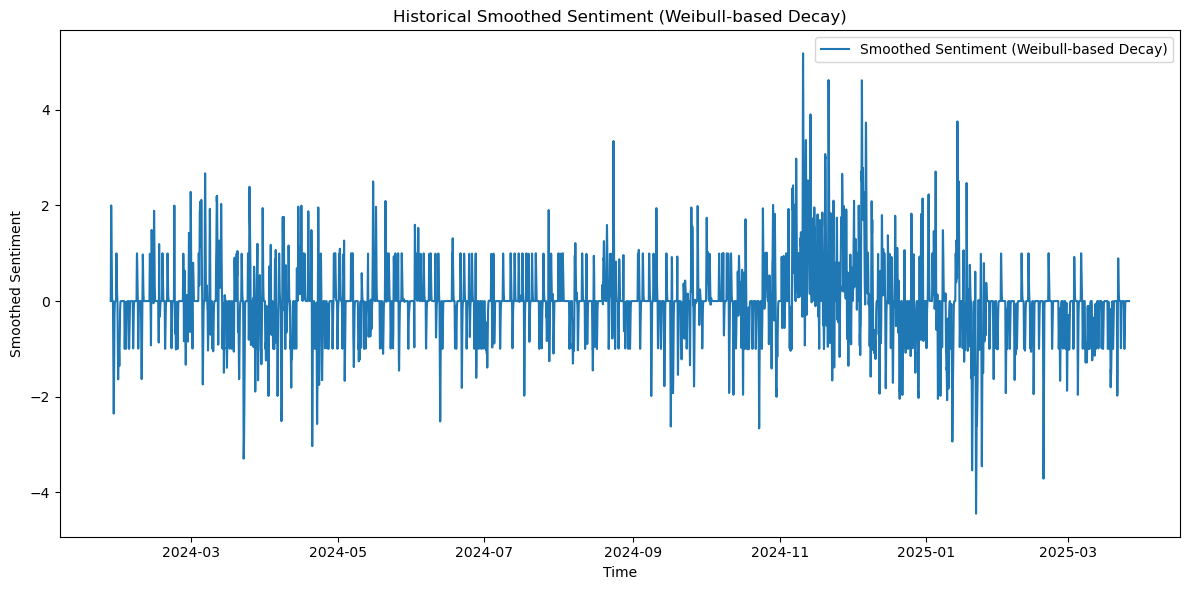

In [6]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt


# Parameters for the Weibull distribution
k = 2.0       # shape parameter (k > 1 gives a peak)
lam = 6.0     # scale parameter in hours (peak attention around ~4.24 hours)
# Determine the mode (peak) of the Weibull PDF and compute its maximum value
x_mode = lam * ((k - 1) / k) ** (1 / k)
max_weight = weibull_min.pdf(x_mode, k, scale=lam)

def weight_function(x):
    """Compute the weight for elapsed time x (in hours) using the Weibull PDF normalized to 1."""
    if x < 0:
        return 0.0
    return weibull_min.pdf(x, k, scale=lam) / max_weight

# Create an hourly date range for the smoothed sentiment time series
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_weibull(t):
    """
    Compute the smoothed sentiment at time t by summing the weighted sentiment scores
    from news events in the last 48 hours.
    """
    # Consider news events from the past 48 hours
    window_start = t - pd.Timedelta(hours=48)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    if df_window.empty:
        return 0.0
    # Compute elapsed time in hours from each news event to time t
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Calculate weights for each news event using the Weibull function
    weights = time_diffs.apply(weight_function)
    # Compute the weighted sum of sentiment scores
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# Compute the smoothed sentiment for each hour in the time series
smoothed_sentiments = [compute_smoothed_sentiment_weibull(t) for t in hourly_index]
df_sentiment['smoothed_sentiment_weibull'] = smoothed_sentiments

# Display the first few rows
print(df_sentiment.head())

# Plot the smoothed sentiment over time
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull'], label='Smoothed Sentiment (Weibull-based Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

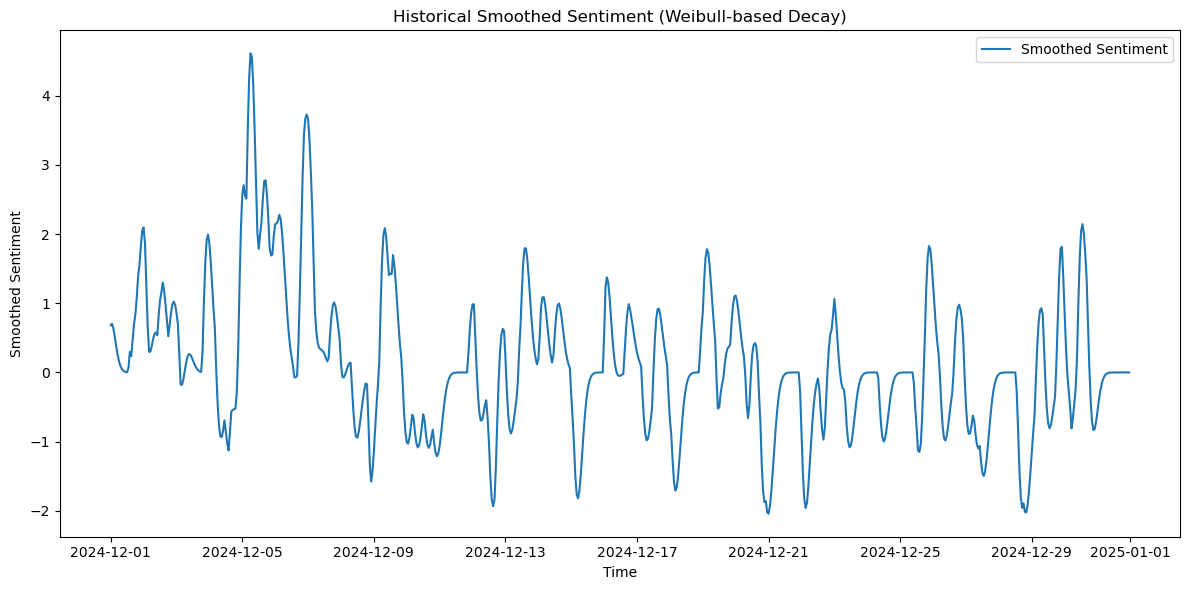

In [7]:
#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment_weibull'], label='Smoothed Sentiment')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

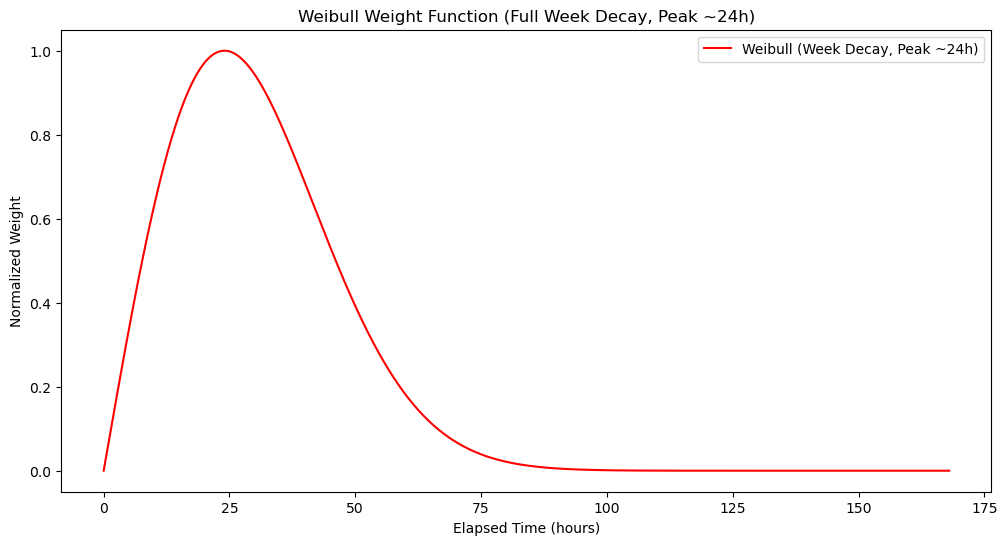

C:\Users\Justin\AppData\Local\Temp\ipykernel_24604\1255718111.py:60: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                           smoothed_sentiment_weibull_week
2024-01-27 13:00:00+00:00                         0.000000
2024-01-27 14:00:00+00:00                         0.027001
2024-01-27 15:00:00+00:00                         0.164191
2024-01-27 16:00:00+00:00                         0.300527
2024-01-27 17:00:00+00:00                         0.435303


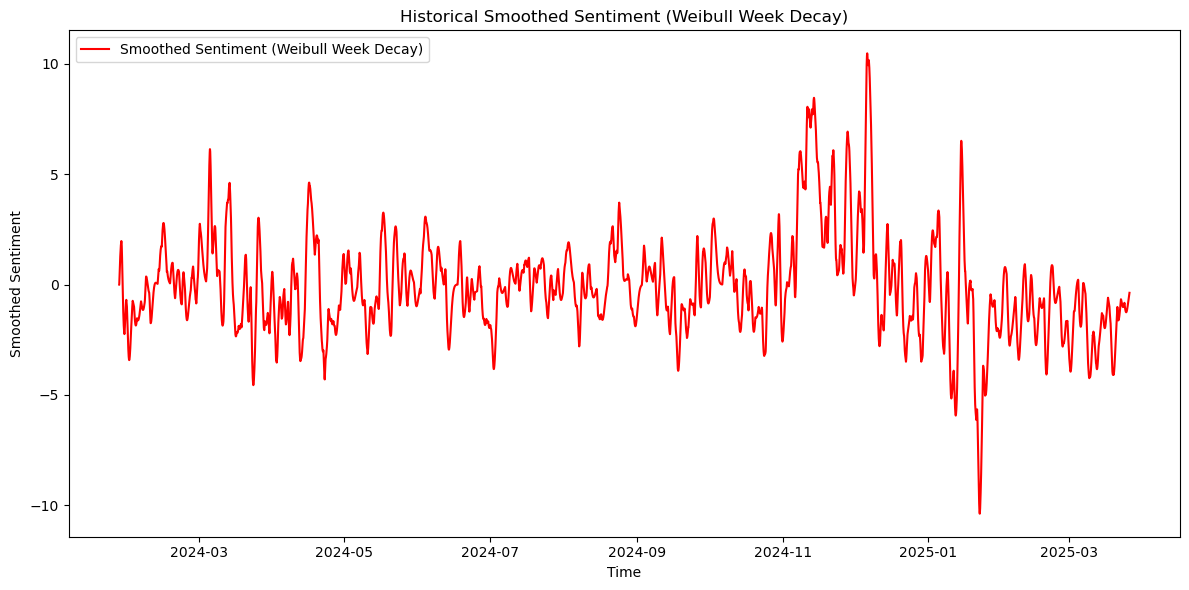

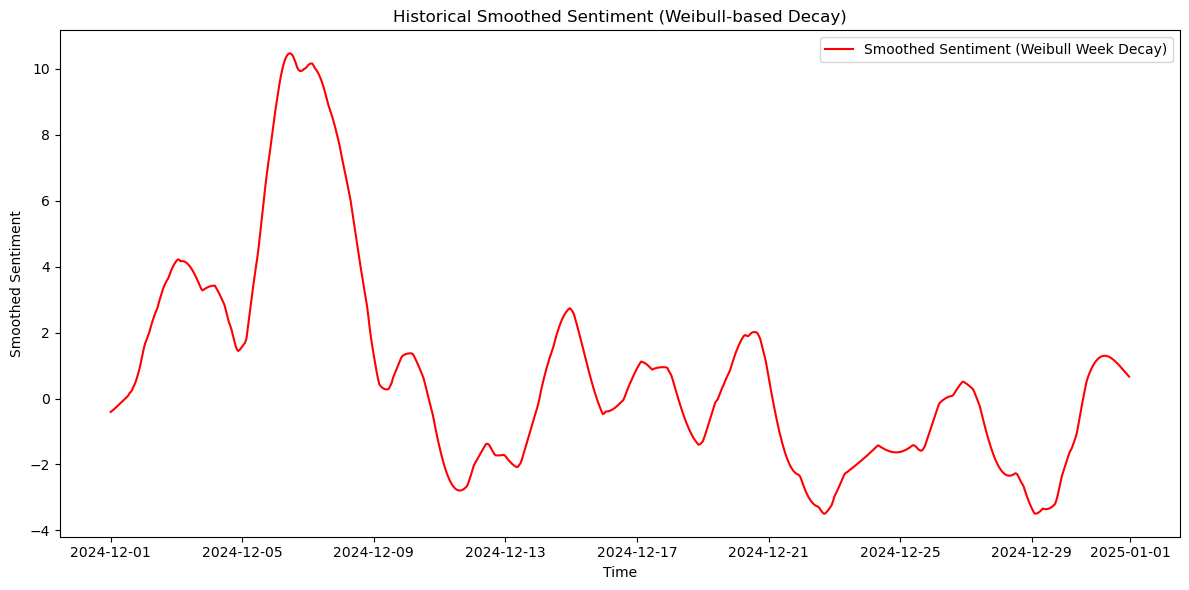

In [8]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt

# --- Alternative Weibull Parameters for a Full Week Decay ---
# We want the mode (peak) to be ~24 hours. For a Weibull with shape k,
# the mode is given by: mode = lam * ((k-1)/k)^(1/k)
# For k = 2.0, set lam such that lam/sqrt(2) = 24 => lam = 24 * sqrt(2)
k_week = 2.0
lam_week = 24 * np.sqrt(2)   # Approximately 33.94 hours
x_mode_week = lam_week * ((k_week - 1) / k_week) ** (1 / k_week)
max_weight_week = weibull_min.pdf(x_mode_week, k_week, scale=lam_week)

def weight_function_week(x):
    """
    Compute the weight for an elapsed time x (in hours) using a Weibull PDF 
    normalized so that the maximum weight is 1.
    
    This function is designed so that the impact of a post increases to a peak 
    around 24 hours and then decays over the course of one week (168 hours).
    """
    if x < 0:
        return 0.0
    return weibull_min.pdf(x, k_week, scale=lam_week) / max_weight_week

# --- For Comparison: Plot the Weight Function ---
x_vals = np.linspace(0, 168, 500)  # from 0 to 168 hours
y_vals = [weight_function_week(x) for x in x_vals]

plt.figure(figsize=(12,6))
plt.plot(x_vals, y_vals, label='Weibull (Week Decay, Peak ~24h)', color='red')
plt.xlabel('Elapsed Time (hours)')
plt.ylabel('Normalized Weight')
plt.title('Weibull Weight Function (Full Week Decay, Peak ~24h)')
plt.legend()
plt.show()

# --- Alternative Smoothed Sentiment Function Using the New Weight Function ---
def compute_smoothed_sentiment_weibull_week(t):
    """
    Compute the smoothed sentiment at time t by summing the weighted sentiment scores
    from news events in the last week (168 hours) using the alternative Weibull function.
    """
    # Consider news events in the last 168 hours (1 week)
    window_start = t - pd.Timedelta(hours=168)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    if df_window.empty:
        return 0.0
    # Calculate the elapsed time in hours since each post
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Apply the alternative Weibull weight function
    weights = time_diffs.apply(weight_function_week)
    # Sum the weighted sentiment scores
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# --- Assuming you have start_time, end_time, and df defined ---
# For example, if:
# start_time = df['created_at'].min().floor('H')
# end_time = df['created_at'].max().ceil('H')
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

# Compute the smoothed sentiment using the alternative function
smoothed_sentiments_week = [compute_smoothed_sentiment_weibull_week(t) for t in hourly_index]

# Save results in a DataFrame for further analysis/plotting
df_sentiment = pd.DataFrame({'smoothed_sentiment_weibull_week': smoothed_sentiments_week}, index=hourly_index)
print(df_sentiment.head())

plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull_week'], label='Smoothed Sentiment (Weibull Week Decay)', color='red')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull Week Decay)')
plt.legend()
plt.tight_layout()
plt.show()

#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment_weibull_week'], label='Smoothed Sentiment (Weibull Week Decay)', color='red')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
#add the smoothed sentiment to the btc data (btc data is already hourly)
btc = pd.read_csv("../data/processed/features_trading_strategy.csv")

btc['datetime'] = pd.to_datetime(btc['datetime'])
btc = btc.set_index('datetime')
btc = btc.join(df_sentiment)
btc = btc.dropna()
print(btc.head())

#add hourly post density from df to btc
df = df.set_index('created_at')
density = df.resample('H').size()
btc['post_density'] = density
#btc = btc.dropna()
print(btc.head())

                               OPEN      HIGH       LOW     CLOSE  \
datetime                                                            
2024-01-27 13:00:00+00:00  41750.00  41806.55  41725.21  41742.44   
2024-01-27 14:00:00+00:00  41742.44  41818.39  41731.01  41766.00   
2024-01-27 15:00:00+00:00  41766.00  41894.87  41733.60  41814.00   
2024-01-27 16:00:00+00:00  41814.00  41895.74  41791.22  41810.18   
2024-01-27 17:00:00+00:00  41810.18  41845.34  41774.07  41779.28   

                           TOTAL_TRADES  TOTAL_TRADES_BUY  TOTAL_TRADES_SELL  \
datetime                                                                       
2024-01-27 13:00:00+00:00         35569             10171              25398   
2024-01-27 14:00:00+00:00         27238             12281              14957   
2024-01-27 15:00:00+00:00         32410             14004              18406   
2024-01-27 16:00:00+00:00         30278             13664              16614   
2024-01-27 17:00:00+00:00         24

C:\Users\Justin\AppData\Local\Temp\ipykernel_24604\235174105.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  density = df.resample('H').size()


In [10]:
btc

,OPEN,HIGH,LOW,CLOSE,TOTAL_TRADES,TOTAL_TRADES_BUY,TOTAL_TRADES_SELL,VOLUME,VOLUME_BUY,VOLUME_SELL,...,OBV,OBV_EMA20,OBV_Signal,H-L,H-PC,L-PC,TR,ATR,smoothed_sentiment_weibull_week,post_density
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-27 13:00:00+00:00,41750.00,41806.55,41725.21,41742.44,35569,10171,25398,419.38468,187.70449,231.68019,...,-419.38468,-65.712408,0,81.34,56.55,24.79,81.34,175.710000,0.000000,2.0
2024-01-27 14:00:00+00:00,41742.44,41818.39,41731.01,41766.00,27238,12281,14957,493.43458,233.95644,259.47814,...,493.43458,-12.460314,1,87.38,75.95,11.43,87.38,140.500000,0.027001,0.0
2024-01-27 15:00:00+00:00,41766.00,41894.87,41733.60,41814.00,32410,14004,18406,581.25856,268.18654,313.07202,...,581.25856,44.084341,0,161.27,128.87,32.40,161.27,109.318333,0.164191,0.0
2024-01-27 16:00:00+00:00,41814.00,41895.74,41791.22,41810.18,30278,13664,16614,609.18361,315.81592,293.36769,...,-609.18361,-18.131655,-1,104.52,81.74,22.78,104.52,101.921667,0.300527,0.0
2024-01-27 17:00:00+00:00,41810.18,41845.34,41774.07,41779.28,24681,9330,15351,448.23397,165.47870,282.75527,...,-448.23397,-59.093780,0,71.27,35.16,36.11,71.27,99.801667,0.435303,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26 08:00:00+00:00,88140.45,88200.00,87886.10,87959.73,59816,30655,29161,525.11331,236.22879,288.88452,...,-525.11331,59.670458,-1,313.90,59.55,254.35,313.90,418.066667,-0.487101,0.0
2025-03-26 09:00:00+00:00,87959.73,88056.61,87837.49,87939.99,43067,23857,19210,393.09750,206.51437,186.58313,...,-393.09750,16.549700,0,219.12,96.88,122.24,219.12,392.118333,-0.456887,0.0
2025-03-26 10:00:00+00:00,87939.99,88259.81,87939.99,88208.47,55584,29793,25791,556.20541,297.60360,258.60181,...,556.20541,67.945482,1,319.82,319.82,0.00,319.82,378.148333,-0.427685,2.0


In [11]:
#save data
btc.to_csv("../data/processed/btc_usdt_hourly_processed_with_sentiment_till_26_march.csv")